In [1]:
# Imports 
import os
import sys
from io import StringIO
sys.path.append("..")
os.environ["pyna_language"] = 'julia'
import pdb
import numpy as np
import openmdao.api as om
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
%matplotlib inline
from pyNA.pyna import pyna

from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Inputs 
z_cb_lst = np.hstack((np.linspace(25, 250, 10), np.linspace(300, 750, 10)))

TS_cb_lst = dict()
TS_cb_lst['stca']= dict()
TS_cb_lst['stca']['V2'] = np.linspace(0.7, 1.0, 13)
TS_cb_lst['stca']['Vmax'] = np.linspace(0.4, 1.0, 25)
TS_cb_lst['a10'] = dict()
TS_cb_lst['a10']['V2'] = np.linspace(0.55, 1.0, 19)
TS_cb_lst['a10']['Vmax'] = np.linspace(0.525, 1.0, 20)

Vmax_lst = dict()
Vmax_lst['stca'] = dict()
Vmax_lst['stca']['V2'] = 197*0.51444444
Vmax_lst['stca']['Vmax'] = 250*0.51444444
Vmax_lst['a10'] = dict()
Vmax_lst['a10']['V2'] = 234.4*0.51444444
Vmax_lst['a10']['Vmax'] = 250*0.51444444

ipnlt_constraint = dict()
ipnlt_constraint['stca'] = 94.7
ipnlt_constraint['a10'] = np.nan

ipnlt_constraint_lst = np.array([94.70693028, 93.35837504]) + 0.25
k_lst = [1.2, 1.4]

# PTCB trajectories

In [3]:
# PTCB - V2
if True:
    
    ac_name = 'stca'
    
    for case in ['Vmax']:
    
        if True:
            # Load verification trajectory 
            nasa_std = pd.read_csv('../cases/nasa_stca_standard/trajectory/Trajectory_to.csv')

            pyna_settings = pyna.load_settings(case_name='stca')
            pyna_settings.engine_file_name = "engine_deck_stca.csv"
            pyna_settings.TS_to = 1.
            pyna_settings.TS_vnrs = TS_cb_lst[ac_name][case][0]
            pyna_settings.TS_cutback = TS_cb_lst[ac_name][case][0]
            pyna_settings.z_cutback = 25.
            pyna_settings.save_results = True
            pyna_settings.levels_int_metric = 'ipnlt'
            pyna_settings.output_directory_name = 'PTCB/'+case+'_new'
            pyna_settings.output_file_name = ac_name+'_ptcb_'+case+'.sql'

            pyna_settings.noise_constraint_lateral = ipnlt_constraint['stca']
            pyna_settings.PTCB = True
            pyna_settings.PKROT = True
            pyna_settings.PHLD = False
            pyna_settings.shielding = False
            pyna_settings.lateral_attenuation = False
            
            pyna_settings.fan_inlet = True
            pyna_settings.fan_discharge = True
            pyna_settings.core = True
            pyna_settings.airframe = False
            pyna_settings.jet_shock = False
            pyna_settings.jet_mixing = True
            pyna_settings.all_sources = False

            # Simplifications
            pyna_settings.N_b = 1
            pyna_settings.max_iter = 150
            pyna_settings.n_order = 3

            py = pyna(pyna_settings)
            py.ac.k_rot = k_lst[0]
            py.ac.v_max = Vmax_lst[ac_name][case]

        if True:
            py.optimize_trajectory_noise(n_sideline=14, init_traj_name=None)

        if True:
            results = py.load_results(file_name=ac_name+'_ptcb_'+case+'.sql')

            path_save_name = 'trajectory_' + ac_name + '_ptcb_' + case + '.csv'
            engine_save_name = 'engine_' + ac_name + '_ptcb_' + case + '.csv' 
            py.save_time_series(results, py.settings, py.ac, path_save_name, engine_save_name)

        if True:
            n_sl = 261  

            py.settings.engine_file_name = 'engine_'+ac_name+'_ptcb_'+case+'.csv'
            py.settings.trajectory_file_name = 'trajectory_'+ac_name+'_ptcb_'+case+'.csv'
            py.settings.output_file_name = ac_name+'_ptcb_'+case+'_noisetimeseries.sql'
            py.settings.observer_lst = ['contour',]
            py.settings.levels_int_metric = 'epnl'

            py.settings.fan_inlet = True
            py.settings.fan_discharge = True
            py.settings.core = True
            py.settings.airframe = True
            py.settings.jet_shock = False
            py.settings.jet_mixing = True
            py.settings.all_sources = False

            x_observer_lst = np.zeros((n_sl+1, 3))
            x_observer_lst[:-1, 0] = np.linspace(0, 6500, n_sl)
            x_observer_lst[:-1, 1] = 450*np.ones(n_sl)
            x_observer_lst[:, 2] = 4*0.3048*np.ones(n_sl+1)
            x_observer_lst[-1,0] = 6500.

            py.settings.x_observer_array = x_observer_lst
            py.compute_noise_time_series()

            epnl_sideline = py.problem.get_val('noise.epnl')[:-1]
            epnl_lateral = np.max(py.problem.get_val('noise.epnl')[:-1])
            epnl_flyover = py.problem.get_val('noise.epnl')[-1]

        if True:
            np.save('../cases/'+ac_name+'/output/PTCB/'+case+'_new/epnl_lateral.npy', epnl_lateral)
            np.save('../cases/'+ac_name+'/output/PTCB/'+case+'_new/epnl_flyover.npy', epnl_flyover)
            np.save('../cases/'+ac_name+'/output/PTCB/'+case+'_new/epnl_sideline.npy', epnl_sideline)

/Users/laurensvoet/Library/Python/3.7/lib/python/site-packages/openmdao/utils/options_dictionary.py:332: OMDeprecationWarning:'gradient method' is not a valid python name and will become an invalid option name in a future release. You can prevent this warning (and future exceptions) by declaring this option using a valid python name.


--- Linkage Report [phases] ---
    --- groundroll - rotation ---
        time           [final] ==  time           [initial]
        states:x       [final] ==  states:x       [initial]
        states:v       [final] ==  states:v       [initial]
        states:alpha   [final] ==  states:alpha   [initial]
    --- rotation - liftoff ---
        time               [final] ==  time             [initial]
        states:x           [final] ==  states:x         [initial]
        parameters:z       [final*] ==  states:z         [initial]
        states:v           [final] ==  states:v         [initial]
        states:alpha       [final] ==  controls:alpha   [initial]
        parameters:gamma   [final*] ==  states:gamma     [initial]
    --- liftoff - vnrs ---
        time             [final] ==  time             [initial]
        states:x         [final] ==  states:x         [initial]
        states:v         [final] ==  states:v         [initial]
        controls:alpha   [final] ==  controls:

/Users/laurensvoet/Library/Python/3.7/lib/python/site-packages/openmdao/recorders/sqlite_recorder.py:224: UserWarning:The existing case recorder file, dymos_solution.db, is being overwritten.


Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Full total jacobian was computed 3 times, taking 4.777070 seconds.
Total jacobian shape: (255, 179) 


Jacobian shape: (255, 179)  ( 3.76% nonzero)
FWD solves: 11   REV solves: 0
Total colors vs. total size: 11 vs 179  (93.9% improvement)

Sparsity computed using tolerance: 1e-12
Time to compute sparsity: 4.777070 sec.
Time to compute coloring: 0.260503 sec.


Optimization Problem -- Optimization using pyOpt_sparse
    Objective Function: _objfunc

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                   10.3176
       User Objective Time :       1.2423
       User Sensitivity Time :     8.2242
       Interface Time :            0.7729
       Opt Solver Time:            0.0782
    Calls to Objective Function :      24
    Calls to Sens Function :           24


   Objectives
     

--- Linkage Report [phases] ---
    --- groundroll - rotation ---
        time           [final] ==  time           [initial]
        states:x       [final] ==  states:x       [initial]
        states:v       [final] ==  states:v       [initial]
        states:alpha   [final] ==  states:alpha   [initial]
    --- rotation - liftoff ---
        time               [final] ==  time             [initial]
        states:x           [final] ==  states:x         [initial]
        parameters:z       [final*] ==  states:z         [initial]
        states:v           [final] ==  states:v         [initial]
        states:alpha       [final] ==  controls:alpha   [initial]
        parameters:gamma   [final*] ==  states:gamma     [initial]
    --- liftoff - vnrs ---
        time             [final] ==  time             [initial]
        states:x         [final] ==  states:x         [initial]
        states:v         [final] ==  states:v         [initial]
        controls:alpha   [final] ==  controls:

/Users/laurensvoet/Library/Python/3.7/lib/python/site-packages/openmdao/recorders/sqlite_recorder.py:224: UserWarning:The existing case recorder file, /Users/laurensvoet/Documents/Research/pyNA/pyNA/cases/stca/output/PTCB/Vmax_new/stca_ptcb_Vmax.sql, is being overwritten.


Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Full total jacobian was computed 3 times, taking 449.019157 seconds.
Total jacobian shape: (263, 194) 


Jacobian shape: (263, 194)  ( 4.42% nonzero)
FWD solves: 14   REV solves: 2
Total colors vs. total size: 16 vs 194  (91.8% improvement)

Sparsity computed using tolerance: 1e-12
Time to compute sparsity: 449.019157 sec.
Time to compute coloring: 0.339653 sec.


KeyboardInterrupt: 



Optimization Problem -- Optimization using pyOpt_sparse
    Objective Function: _objfunc

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                11168.4547
       User Objective Time :     169.4521
       User Sensitivity Time : 10830.7984
       Interface Time :            5.1741
       Opt Solver Time:          163.0301
    Calls to Objective Function :      78
    Calls to Sens Function :           63


   Objectives
      Index  Name                     Value          Optimum
          0  noise.flyover     8.341543E+01     0.000000E+00

   Variables (c - continuous, i - integer, d - discrete)
      Index  Name                                                                   Type      Lower Bound            Value      Upper Bound     Status
          0  phases.groundroll.parameters:k_rot_0                                      c     1.100000E+00     1.448609E+00     1.600000E+00           
          1  phases.

/Users/laurensvoet/Library/Python/3.7/lib/python/site-packages/openmdao/recorders/sqlite_recorder.py:224: UserWarning:The existing case recorder file, /Users/laurensvoet/Documents/Research/pyNA/pyNA/cases/stca/output/stca_ptcb_Vmax_noisetimeseries.sql, is being overwritten.
/Users/laurensvoet/Library/Python/3.7/lib/python/site-packages/openmdao/recorders/sqlite_recorder.py:224: UserWarning:The existing case recorder file, /Users/laurensvoet/Documents/Research/pyNA/pyNA/cases/stca/dymos_solution.db, is being overwritten.


Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.


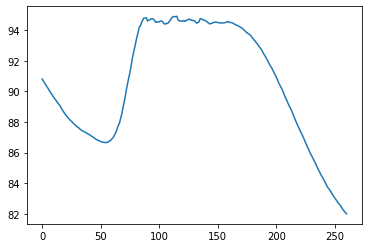

In [4]:
plt.plot(epnl_sideline)

In [12]:
py.problem.get_val('phases.liftoff.timeseries.time')

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [ ]:
plt.plot(t)

In [ ]:
# PTCB - Vmax
if True:
    # Load verification trajectory 
    nasa_std = pd.read_csv('../cases/nasa_stca_standard/trajectory/Trajectory_to.csv')

    pyna_settings = pyna.load_settings(case_name='stca')
    pyna_settings.engine_file_name = "engine_deck_stca.csv"
    pyna_settings.TS_to = 1.
    pyna_settings.TS_vnrs = 0.475
    pyna_settings.TS_cutback = 0.475
    pyna_settings.z_cutback = 25.
    pyna_settings.save_results = True
    pyna_settings.levels_int_metric = 'ipnlt'
    pyna_settings.output_directory_name = 'PTCB/Vmax_final'
    pyna_settings.output_file_name = 'stca_ptcb_vmax.sql'

    pyna_settings.noise_constraint_lateral = ipnlt_constraint_lst[1]
    pyna_settings.PTCB = True
    pyna_settings.PKROT = True
    pyna_settings.PHLD = False
    pyna_settings.shielding = False
    
    pyna_settings.fan_inlet = True
    pyna_settings.fan_discharge = True
    pyna_settings.core = True
    pyna_settings.airframe = False
    pyna_settings.jet_shock = False
    pyna_settings.jet_mixing = True
    pyna_settings.all_sources = False

    # Simplifications
    pyna_settings.N_b = 1
    pyna_settings.max_iter = 200
    pyna_settings.n_order = 3

    py = pyna(pyna_settings)
    py.ac.k_rot = k_lst[1]
#     py.ac.v_max = nasa_std['V [m/s]'].values[-1]

    if True:
        py.optimize_trajectory_noise(n_sideline=24, init_traj_name=None)

    if True:
        results = py.load_results(file_name='stca_ptcb_vmax.sql')

        path_save_name = 'Trajectory_stca_ptcb_vmax.csv'
        engine_save_name = 'engine_stca_ptcb_vmax.csv' 
        py.save_time_series(results, py.settings, py.ac, path_save_name, engine_save_name)
        
    if True:
        n_sl = 161  

        py.settings.engine_file_name = 'engine_stca_ptcb_vmax.csv'
        py.settings.trajectory_file_name = 'Trajectory_stca_ptcb_vmax.csv'
        py.settings.output_file_name = 'stca_ptcb_noisetimeseries.sql'
        py.settings.observer_lst = ['contour',]
        py.settings.levels_int_metric = 'epnl'

        py.settings.fan_inlet = True
        py.settings.fan_discharge = True
        py.settings.core = True
        py.settings.airframe = True
        py.settings.jet_shock = False
        py.settings.jet_mixing = True
        py.settings.all_sources = False
        
        x_observer_lst = np.zeros((n_sl+1, 3))
        x_observer_lst[:-1, 0] = np.linspace(0, 10000, n_sl)
        x_observer_lst[:-1, 1] = 450*np.ones(n_sl)
        x_observer_lst[:, 2] = 4*0.3048*np.ones(n_sl+1)
        x_observer_lst[-1,0] = 6500.

        py.settings.x_observer_array = x_observer_lst
        py.compute_noise_time_series()

        epnl_sideline = py.problem.get_val('noise.epnl')[:-1]
        epnl_lateral = np.max(py.problem.get_val('noise.epnl')[:-1])
        epnl_flyover = py.problem.get_val('noise.epnl')[-1]

    if True:
        np.save('../cases/stca/output/PTCB/Vmax_final/epnl_lateral_vmax.npy', epnl_lateral)
        np.save('../cases/stca/output/PTCB/Vmax_final/epnl_flyover_vmax.npy', epnl_flyover)
        np.save('../cases/stca/output/PTCB/Vmax_final/epnl_sideline_vmax.npy', epnl_sideline)

# PHLD trajectories

In [ ]:
# PTCB - V2
if False:
    # Load verification trajectory 
    nasa_std = pd.read_csv('../cases/nasa_stca_standard/trajectory/Trajectory_to.csv')

    pyna_settings = pyna.load_settings(case_name='stca')
    pyna_settings.engine_file_name = "engine_deck_stca.csv"
    pyna_settings.TS_to = 1.
    pyna_settings.TS_vnrs = 0.56
    pyna_settings.TS_cutback = 0.56
    pyna_settings.z_cutback = 25.
    pyna_settings.save_results = True
    pyna_settings.levels_int_metric = 'ipnlt'
    pyna_settings.output_directory_name = 'PHLD/V2_final'
    pyna_settings.output_file_name = 'stca_phld_v2.sql'

    pyna_settings.noise_constraint_lateral = ipnlt_constraint_lst[0]
    pyna_settings.PTCB = True
    pyna_settings.PKROT = True
    pyna_settings.PHLD = True
    pyna_settings.shielding = False
    
    pyna_settings.fan_inlet = True
    pyna_settings.fan_discharge = True
    pyna_settings.core = True
    pyna_settings.airframe = False
    pyna_settings.jet_shock = False
    pyna_settings.jet_mixing = True
    pyna_settings.all_sources = False

    # Simplifications
    pyna_settings.N_b = 1
    pyna_settings.max_iter = 300
    pyna_settings.n_order = 3

    py = pyna(pyna_settings)
    py.ac.k_rot = 1.23516777
    py.ac.v_max = nasa_std['V [m/s]'].values[-1]

    if True:
        py.optimize_trajectory_noise(n_sideline=24, init_traj_name='stca_ptcb_v2.sql')

    if True:
        results = py.load_results(file_name='stca_phld_v2.sql')

        path_save_name = 'Trajectory_stca_phld_v2.csv'
        engine_save_name = 'engine_stca_phld_v2.csv' 
        py.save_time_series(results, py.settings, py.ac, path_save_name, engine_save_name)
        
    if True:
        n_sl = 161  

        py.settings.engine_file_name = 'engine_stca_phld_v2.csv'
        py.settings.trajectory_file_name = 'Trajectory_stca_phld_v2.csv'
        py.settings.output_file_name = 'stca_phld_v2_noisetimeseries.sql'
        py.settings.observer_lst = ['contour',]
        py.settings.levels_int_metric = 'epnl'

        py.settings.fan_inlet = True
        py.settings.fan_discharge = True
        py.settings.core = True
        py.settings.airframe = True
        py.settings.jet_shock = False
        py.settings.jet_mixing = True
        py.settings.all_sources = False
        
        x_observer_lst = np.zeros((n_sl+1, 3))
        x_observer_lst[:-1, 0] = np.linspace(0, 10000, n_sl)
        x_observer_lst[:-1, 1] = 450*np.ones(n_sl)
        x_observer_lst[:, 2] = 4*0.3048*np.ones(n_sl+1)
        x_observer_lst[-1,0] = 6500.

        py.settings.x_observer_array = x_observer_lst
        py.compute_noise_time_series()

        epnl_sideline = py.problem.get_val('noise.epnl')[:-1]
        epnl_lateral = np.max(py.problem.get_val('noise.epnl')[:-1])
        epnl_flyover = py.problem.get_val('noise.epnl')[-1]

    if True:
        np.save('../cases/stca/output/PHLD/V2_final/epnl_lateral_v2.npy', epnl_lateral)
        np.save('../cases/stca/output/PHLD/V2_final/epnl_flyover_v2.npy', epnl_flyover)
        np.save('../cases/stca/output/PHLD/V2_final/epnl_sideline_v2.npy', epnl_sideline)

In [ ]:
# PTCB - Vmax
if False:
    # Load verification trajectory 
    nasa_std = pd.read_csv('../cases/nasa_stca_standard/trajectory/Trajectory_to.csv')

    pyna_settings = pyna.load_settings(case_name='stca')
    pyna_settings.engine_file_name = "engine_deck_stca.csv"
    pyna_settings.TS_to = 1.
    pyna_settings.TS_vnrs = 0.475
    pyna_settings.TS_cutback = 0.475
    pyna_settings.z_cutback = 25.
    pyna_settings.save_results = True
    pyna_settings.levels_int_metric = 'ipnlt'
    pyna_settings.output_directory_name = 'PHLD/Vmax_final'
    pyna_settings.output_file_name = 'stca_phld_vmax.sql'

    pyna_settings.noise_constraint_lateral = ipnlt_constraint_lst[1]
    pyna_settings.PTCB = True
    pyna_settings.PKROT = True
    pyna_settings.PHLD = True
    pyna_settings.shielding = False
    
    pyna_settings.fan_inlet = True
    pyna_settings.fan_discharge = True
    pyna_settings.core = True
    pyna_settings.airframe = False
    pyna_settings.jet_shock = False
    pyna_settings.jet_mixing = True
    pyna_settings.all_sources = False

    # Simplifications
    pyna_settings.N_b = 1
    pyna_settings.max_iter = 150
    pyna_settings.n_order = 3

    py = pyna(pyna_settings)
    py.ac.k_rot = k_lst[1]
#     py.ac.v_max = nasa_std['V [m/s]'].values[-1]

    if True:
        py.optimize_trajectory_noise(n_sideline=24, init_traj_name=None)

    if True:
        results = py.load_results(file_name='stca_phld_vmax.sql')

        path_save_name = 'Trajectory_stca_phld_vmax.csv'
        engine_save_name = 'engine_stca_phld_vmax.csv' 
        py.save_time_series(results, py.settings, py.ac, path_save_name, engine_save_name)
        
    if True:
        n_sl = 161  

        py.settings.engine_file_name = 'engine_stca_phld_vmax.csv'
        py.settings.trajectory_file_name = 'Trajectory_stca_phld_vmax.csv'
        py.settings.output_file_name = 'stca_phld_noisetimeseries.sql'
        py.settings.observer_lst = ['contour',]
        py.settings.levels_int_metric = 'epnl'

        py.settings.fan_inlet = True
        py.settings.fan_discharge = True
        py.settings.core = True
        py.settings.airframe = True
        py.settings.jet_shock = False
        py.settings.jet_mixing = True
        py.settings.all_sources = False
        
        x_observer_lst = np.zeros((n_sl+1, 3))
        x_observer_lst[:-1, 0] = np.linspace(1500, 5500, n_sl)
        x_observer_lst[:-1, 1] = 450*np.ones(n_sl)
        x_observer_lst[:, 2] = 4*0.3048*np.ones(n_sl+1)
        x_observer_lst[-1,0] = 6500.

        py.settings.x_observer_array = x_observer_lst
        py.compute_noise_time_series()

        epnl_sideline = py.problem.get_val('noise.epnl')[:-1]
        epnl_lateral = np.max(py.problem.get_val('noise.epnl')[:-1])
        epnl_flyover = py.problem.get_val('noise.epnl')[-1]

    if True:
        np.save('../cases/stca/output/PHLD/Vmax_final/epnl_lateral_vmax.npy', epnl_lateral)
        np.save('../cases/stca/output/PHLD/Vmax_final/epnl_flyover_vmax.npy', epnl_flyover)
        np.save('../cases/stca/output/PHLD/Vmax_final/epnl_sideline_vmax.npy', epnl_sideline)

In [ ]:
py.settings.output_directory_name = 'PHLD/V2_final'

In [ ]:
py.settings.output_directory_name = 'PTCB/V2_final'
res_ptcb = py.load_results('stca_ptcb_v2.sql')
py.settings.output_directory_name = 'PTCB/Vmax_final'
res_phld = py.load_results('stca_ptcb_vmax.sql')

In [ ]:
plt.figure(figsize=(25,5))
plt.style.use('../utils/plot.mplstyle')
plt.plot(res_ptcb.get_val('trajectory.x'), res_ptcb.get_val('trajectory.L')/res_ptcb.get_val('trajectory.D'))
plt.plot(res_phld.get_val('trajectory.x'), res_phld.get_val('trajectory.L')/res_phld.get_val('trajectory.D'))

plt.plot([res_phld.get_val('trajectory.x')[10], res_phld.get_val('trajectory.x')[10]], [0, 12])

# plt.xlim([0, 3000])
# plt.ylim([-100, 200])

In [ ]:
A = np.vstack((res_ptcb.get_val('phases.vnrs.interpolated.L')/res_ptcb.get_val('phases.vnrs.interpolated.D'),
           res_ptcb.get_val('phases.cutback.interpolated.L')/res_ptcb.get_val('phases.cutback.interpolated.D'))).flatten()
np.mean(A)

In [ ]:
plt.plot(py.problem_init.get_val('trajectory.t_s'), py.problem_init.get_val('trajectory.v'),)

In [ ]:
t=[3.1208792624582404, 5.725406950776218, 8.254417930584905, 10.710006034729485, 13.10011912026004, 15.43691189471588, 17.738496416478565, 20.04927983374366, 22.464575720597576, 25.134479572770573, 25.618688960634245, 26.112183392717444, 26.614518661095634, 27.12516024818925, 27.64350379610352, 28.168957720309894, 28.700933639916517, 29.238728578127436, 3.1183018013001322, 3.2016351346334657, 3.2849684679667988, 3.3683018013001322, 3.4516351346334657, 3.5349684679667988, 3.6183018013001322, 3.7016351346334657, 3.7849684679667988, 3.8683018013001322, 3.9516351346334657, 4.034968467966799, 32.69558225864691, 35.439160448248444, 38.207357655725545, 40.990528190075416, 43.78385574740567, 46.58437311315763, 49.390259312483074, 52.20035641218071, 55.01389568688936, 57.83033233487271, 60.64928142714912, 63.47044727722133, 66.29361681899856, 69.11861770556885, 71.94531744228568, 74.773616531865, 77.60342860919086, 80.43468229641779, 83.26732490738054, 86.10130587532852, 88.93658208565232, 91.77312287514387, 94.14542286805789, 96.51856666404097, 98.89254262805184, 101.26733658520641, 103.64293555071772, 106.0193312901411, 108.39651261799045, 110.7744691343821, 113.15319478389398, 115.53268034351068, 117.91291713183693, 120.29390054116016, 122.67562268575497, 125.05807606911625, 127.44125707545284, 129.825158762628, 132.20977447771924, 134.59510130286478, 136.981132981635, 139.36786347866632, 141.75529037865036, 144.14340793051937, 146.5322105585132, 148.9216962164221, 151.31185954557674, 153.70269533455428, 156.09420181366224, 158.48637393398533, 160.87920677030027, 163.27269876353205, 165.66684511371596, 168.06164112663794, 170.45708540604952, 172.85317335585543, 175.24990047279698, 177.64726548827136]
pnlt=[65.15657787887108, 65.68109842494141, 66.76410000754912, 68.48358616499712, 70.87156499219051, 73.92515422903631, 77.61235180887786, 81.61178262525351, 85.06519479658616, 87.09267774166412, 87.11425880405096, 86.96172931549451, 86.57385006765712, 86.32117563222843, 85.90517405269867, 85.52856664580816, 85.20599283765536, 84.81852638869347, 67.08113879025856, 67.08113879025856, 67.08113879025858, 67.08113879025856, 67.08113879025856, 67.08113879025858, 67.08113879025856, 67.08113879025856, 67.08113879025858, 67.08113879025856, 67.08113879025856, 67.08113879025858, 78.38377442049176, 77.91661481349185, 74.8751958344436, 73.12404579742939, 71.41711973455558, 69.85359340893054, 68.32153190027103, 66.28625306497337, 64.66811165127359, 62.30265455126635, 61.44055476634403, 60.59483264810387, 58.83524312968366, 57.58139204773731, 56.572924034056115, 55.68114587348835, 54.78587272843192, 53.92760400714473, 53.091199337445595, 52.20112277984349, 51.34818348848965, 50.1884411608304, 49.474586898138696, 48.73393718093978, 48.05165485609871, 47.36685148198825, 46.68097998689201, 45.9507102407612, 45.222243118742234, 44.5449723407848, 43.893521308919894, 43.2152991048285, 42.53182065919404, 41.913280089543385, 41.28066545489871, 40.60686761700236, 39.984516627187375, 39.373985445939944, 38.806597531321685, 38.219013426434, 37.587253970579404, 36.947492081119314, 36.36573491845338, 35.84249878315732, 35.32056772987221, 34.78572695919994, 34.19509867672202, 33.58527308385218, 32.99265350015539, 32.42267198782387, 31.858410810061034, 31.32535265658148, 30.776930984484974, 30.219537084576526, 29.66384752973793, 29.10797271252487, 28.54414677088539, 27.96223600267925]

In [ ]:
plt.plot(t, pnlt)